# import他

In [1]:
RANDOM_STATE = 0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations_with_replacement

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from sklearn.datasets import load_digits

# dataを取得・確認

In [2]:
digits = load_digits(n_class=10)

- とりあえず画像ではなく特徴（px値？）行列を取得

In [3]:
X = digits["data"]
y = digits["target"]

- 値域、階調数など確認

In [4]:
print(X.max())
print(X.min())
print(np.unique(X))
print(X.mean())
print(X.std())

16.0
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
4.884164579855314
6.016787548672236


- 画像化

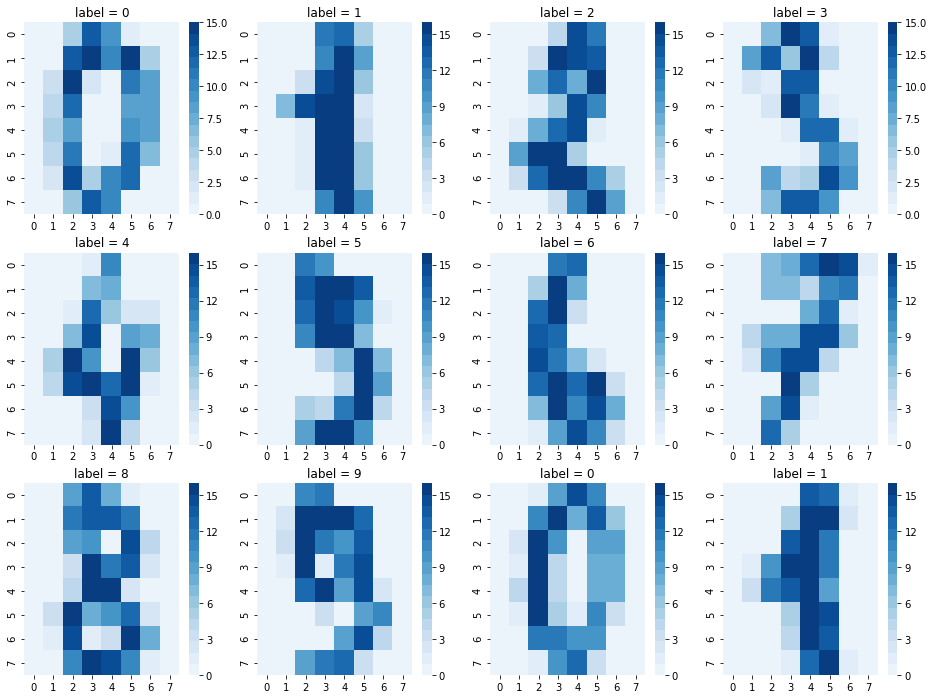

In [5]:
plt.figure(figsize=(16, 12))
for i in range(12):
    plt.subplot(3, 4, i+1)
    sns.heatmap(X[i].reshape(8, 8), cmap=sns.color_palette("Blues", 17))
    plt.title("label = %d" % (y[i]))
plt.show()
plt.close()

- ラベル数をカウント。ついでにラベルのユニーク値取得

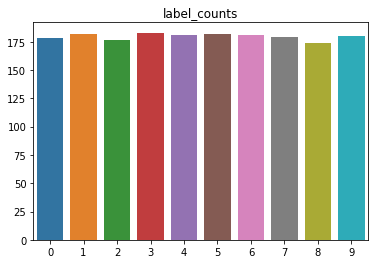

In [6]:
label_counts = pd.Series(y).value_counts().sort_index()
sns.barplot(label_counts.index, label_counts.values)
plt.title("label_counts")
plt.show()
plt.close()

In [7]:
unique_labels = label_counts.index.values

# 次元削減ごっこ

In [8]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [9]:
def show_scatter_by_label(X, y, labels):
    labels = set(labels)
    for l in labels:
        ind = y == l
        sns.scatterplot(X[ind, 0], X[ind, 1], label=l)
    plt.show()
    plt.close()

### PCA

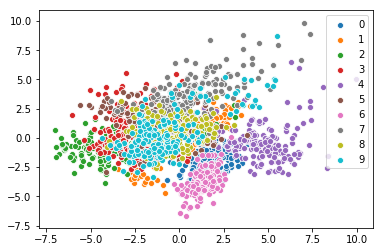

In [10]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_sc)
show_scatter_by_label(X_pca, y, unique_labels)

### kernelPCA

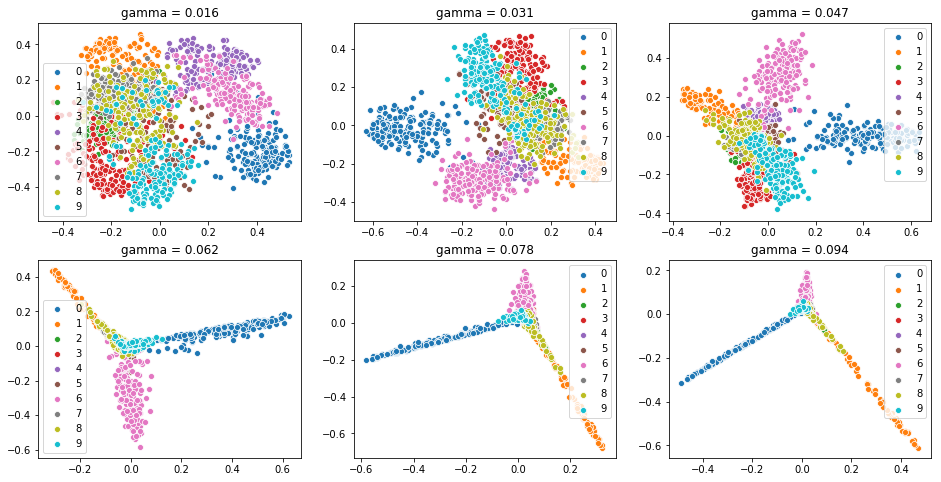

In [11]:
plt.figure(figsize=(16, 8))
for i, gamma in enumerate(np.arange(1, 7) * 1/X.shape[1]):
    plt.subplot(2, 3, i+1)
    kpca = KernelPCA(n_components=2, kernel="rbf", gamma=gamma, random_state=RANDOM_STATE)
    X_kpca = kpca.fit_transform(X_sc)
    for l in unique_labels:
        ind = y == l
        sns.scatterplot(X_kpca[ind, 0], X_kpca[ind, 1], label=l)
    plt.title("gamma = %1.3f" % gamma)
plt.show()
plt.close()

### tSNE

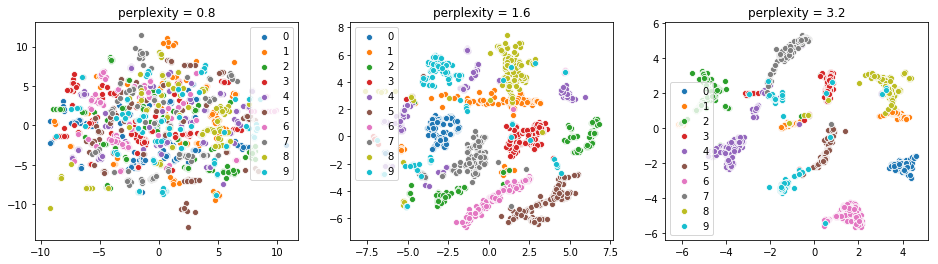

In [12]:
plt.figure(figsize=(16, 4))
for i, perplexity in enumerate(0.1 * 2 ** np.arange(3, 6)):
    plt.subplot(1, 3, i+1)
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=250, random_state=RANDOM_STATE)
    X_tsne = tsne.fit_transform(X_sc)
    for l in unique_labels:
        ind = y == l
        sns.scatterplot(X_tsne[ind, 0], X_tsne[ind, 1], label=l)
    plt.title("perplexity = %1.1f" % perplexity)
plt.show()
plt.close()

### 次元削減シミュレーション

In [13]:
def get_emurated_decomposited_X(X_train, X_decomposited, beta=1e-3, lam=1e-6):
    """
        参考　https://qiita.com/wsuzume/items/26a7c08f00f59992561f
        Xからグラム行列K求めてBとかければ未知データにもきちんと写像できるとか。

        beta: 
            ガウスカーネル用のハイパーパラメータ
        lam: 
            ？？？
    """
    # グラム行列を計算
    n_samples, n_features = X_train.shape
    K = np.zeros((n_samples, n_samples))
    for i, j in combinations_with_replacement(range(n_samples), 2):
        K[i][j] = np.exp(- beta * np.sum((X_train[j] - X_train[i])**2))
        K[j][i] = K[i][j]

    # 重みBを求めて近似
    B = np.linalg.inv(K + lam * np.eye(n_samples)).dot(X_decomposited)
    X_emurated = K.dot(B)

    return X_emurated

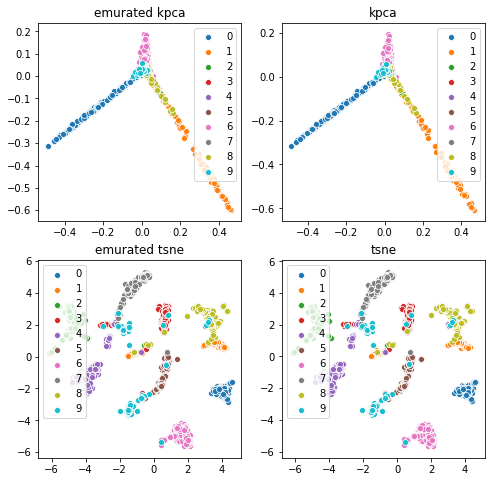

In [14]:
plt.figure(figsize=(8, 8))
i = 0
for method, X_decomposited in zip(["kpca", "tsne"], [X_kpca, X_tsne]):
    i += 1
    plt.subplot(2, 2, i)
    X_emurated = get_emurated_decomposited_X(X_train=X_sc, X_decomposited=X_decomposited)
    for l in unique_labels:
        ind = y == l
        sns.scatterplot(X_emurated[ind, 0], X_emurated[ind, 1], label=l)
    plt.title("emurated %s" % method)

    i += 1
    plt.subplot(2, 2, i)
    for l in unique_labels:
        ind = y == l
        sns.scatterplot(X_decomposited[ind, 0], X_decomposited[ind, 1], label=l)
    plt.title(method)
plt.show()
plt.close()